# Intro

This notebook uses a pretrained segmentation model to predict real retail products .... TODO

In [1]:
from dataclasses import dataclass
import pickle

import requests
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt

import h5py

import warnings
from typing import (
    Tuple,
    List
)

from PIL import Image

from scipy.signal import medfilt
import skimage.morphology
import skimage.transform
from skimage.measure import regionprops

import torch
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models

# Need to do this unless only state is stored
import sys
sys.path.insert(0, '../unet_segmentation')

FEATURE_LENGTH = 2048

In [2]:
warnings.warn('fsafsad')

/home/dani/anaconda3/envs/unet/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: fsafsad
  """Entry point for launching an IPython kernel.


In [3]:
unet = torch.load('unet.pt', map_location=torch.device('cpu'))

## Load image

In [4]:
img = Image.open('example.jpg')

In [5]:
# TODO: move code to data/inference.py
def preprocess(img: Image, img_size: int) -> torch.Tensor:
    preprocess_pipeline = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0,), std=(1,))
    ])
    return preprocess_pipeline(img).unsqueeze(0)

def prediction_map(img: Image, img_size: int = 512) -> np.ndarray:
    """ Returns an image (same shape as original) with class per pixel """
    prediction = unet(preprocess(img, img_size))
    return torch.argmax(prediction, dim=1).squeeze(0).numpy()

prediction = prediction_map(img)

# Load class map

In [6]:
# TODO: use labels.json
class_id_to_name = {
    0: 'Background',
    1: 'Trousers',
    2: 'Skirt',
    3: 'Top',
    4: 'Dress',
    5: 'Outwear',
    6: 'Shorts'
}

# Filter spurious predictions

In [7]:
@dataclass
class DetectedClass(object):

    area_ratio: float
    class_name: str
    class_id: int

        
def _detected_classes(img: np.ndarray, ) -> List[DetectedClass]:
    predicted_classes = [class_id
                         for class_id in np.unique(img) if class_id != 0]
    img_area = img.shape[0] * img.shape[1]
    return [
        DetectedClass(area_ratio=(img == class_id).sum() / img_area,
                      class_name=class_id_to_name[class_id],
                      class_id=class_id)
        for class_id in predicted_classes
    ]


def _detections_to_bg(detections: List[DetectedClass], img: np.ndarray) -> np.ndarray:
    result = img.copy()
    for detection in detections:
        result[result == detection.class_id] = 0
    return result

classes = _detected_classes(prediction)
spurious_classes = list(filter(lambda x: x.area_ratio < 0.05, classes))
detected_classes = list(filter(lambda x: x.area_ratio >= 0.05, classes))
predicted_clean_classes = _detections_to_bg(spurious_classes, prediction)

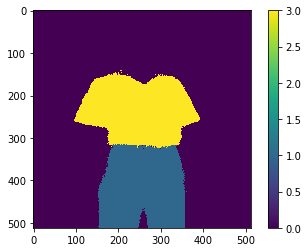

In [8]:
plt.imshow(predicted_clean_classes)
plt.colorbar()

## Post-process masks

In [9]:
@dataclass
class DetectedObject(DetectedClass):

    binary_mask: np.ndarray
            
    @staticmethod
    def from_detection(binary_mask: np.ndarray,
                       detection: DetectedClass):
        return DetectedObject(
            binary_mask=binary_mask,
            area_ratio=detection.area_ratio,
            class_name=detection.class_name,
            class_id=detection.class_id
        )

    def resize(self, img: Image):
        width, height = img.size
        new_binary_mask = skimage.transform.resize(
            self.binary_mask,
            (height, width),
            anti_aliasing=False,
            order=0,  # mode=nearest
            preserve_range=True).astype('uint8')
        
        return DetectedObject(
            binary_mask=new_binary_mask,
            area_ratio=self.area_ratio,
            class_name=self.class_name,
            class_id=self.class_id
        )

    def mask_to_image(self, img: Image) -> Image:
        detected_region = regionprops(self.binary_mask)
        
        if len(detected_region) != 1:
            warning.warn('Should there only be one region in the mask.'
                         f'Found: {len(detected_region)}')
        
        top, left, bottom, right = detected_region[0].bbox
        return img.crop((left, top, right, bottom))

    def display(self, img: Image) -> None:
        plt.imshow(np.array(img))
        plt.imshow(self.binary_mask, cmap='jet', alpha=0.65)
        plt.show()


def locate_detection(detection: DetectedClass, img: np.ndarray) -> DetectedObject:
    # Create binary mask for detection
    binary_img = np.zeros((img.shape))
    class_idxs = np.where(img == detection.class_id)
    binary_img[class_idxs] = 1
    
    # Closing to remove spurious pixels
    closed_img = skimage.morphology.closing(binary_img)
    # Smooth edges with median filtering
    smoothed_img = medfilt(closed_img, kernel_size=7)
    return DetectedObject.from_detection(
        binary_mask=smoothed_img,
        detection=detection
    )

sample = locate_detection(detected_classes[0], prediction)

# Resize mask

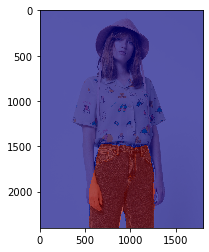

In [10]:
resized_sample = sample.resize(img)
resized_sample.display(img)

# Create feature extractor from model

In [11]:
class FeatureExtractor(torch.nn.Module):
    
    def __init__(self, original_model: torch.nn.Module):
        super(FeatureExtractor, self).__init__()
        self.features = torch.nn.Sequential(
            *list(original_model.children())[:-1],
            
        )
        
    def forward(self, x):
        x = self.features(x)
        return x

resnet152 = models.resnet152(pretrained=True)
feature_extractor = FeatureExtractor(resnet152)

# Extract features

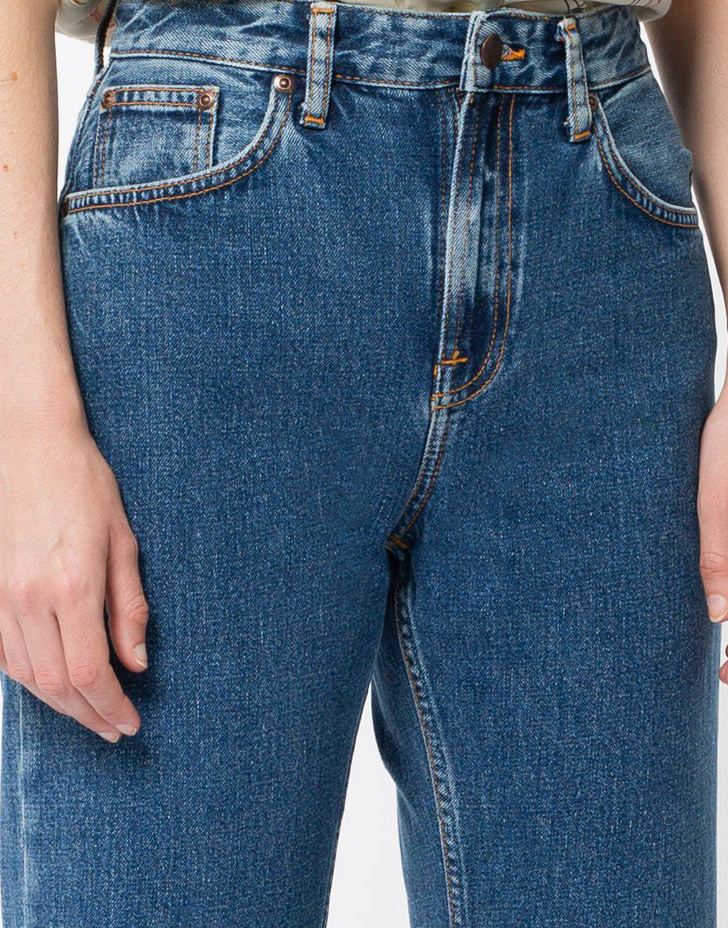

In [12]:
pants = resized_sample.mask_to_image(img)
pants

In [ ]:
import tensorflow as tf
xception_model = tf.keras.applications.xception.Xception(weights='imagenet',
                                                         include_top=False,
                                                         pooling='avg')

def extract_features(img: Image, img_size: int = 256) -> np.ndarray:
    """ Returns an image (same shape as original) with class per pixel """
    skimage.r
    xception_model(np.expand_dims(np.array(img), axis=0).astype(float)).shape
    return feature_extractor(preprocess(img, img_size)).squeeze()\
                                                       .detach()\
                                                       .numpy()

features = extract_features(pants)
assert FEATURE_LENGTH == features.shape[0]

In [13]:
def extract_features(img: Image, img_size: int = 256) -> np.ndarray:
    """ Returns an image (same shape as original) with class per pixel """
    return feature_extractor(preprocess(img, img_size)).squeeze()\
                                                       .detach()\
                                                       .numpy()

features = extract_features(pants)
assert FEATURE_LENGTH == features.shape[0]

# Extract features from products

In [14]:
@dataclass
class Product(object):
    
    url: str
    image_url: str
    name: str
    section: str


with open('products.pickle', 'rb') as handle:
    products = pickle.load(handle)
    
sample = products[679]

Get prediction for product.

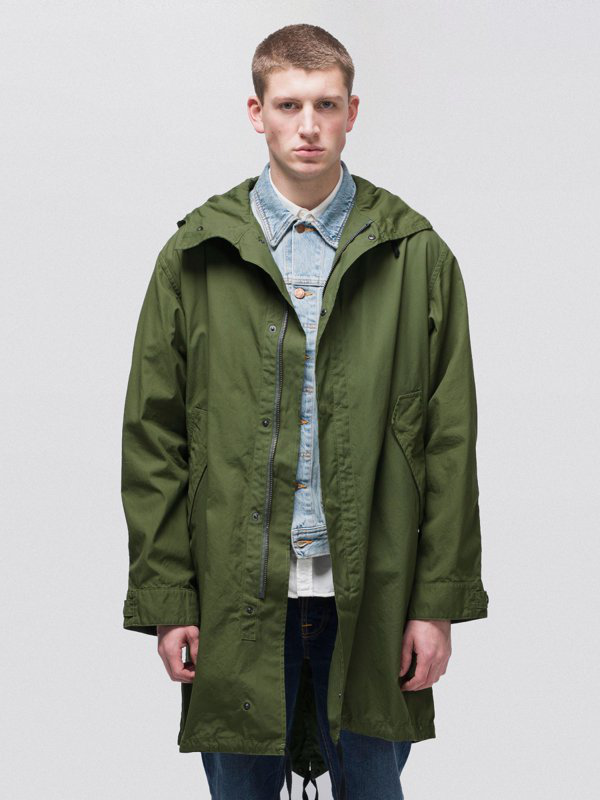

In [15]:
def url_to_PIL(url: str) -> Image:
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

product_img = url_to_PIL(url=sample.image_url)
prediction = prediction_map(product_img)
product_img

Get only reliable predictions:
    - Those big enough
    - Those whose category relates to expected product category

In [16]:
section_to_class_id = {
    'jeans': [1, 6],
    'pants': [1, 6],
    'shorts': [6, 1],
    'denim-jackets': [5, 3],
    'jackets': [5, 3],
    'shirts': [3]
}


def get_detections(class_image: np.ndarray,
                   product: Product,
                   class_area_thresh: float = 0.01) -> DetectedObject:
    """ Return relevant and robust detections sorted by area """
    detections = _detected_classes(class_image)
    # Get only predictions with enough area
    strong_detections = list(
        filter(lambda x: x.area_ratio >= class_area_thresh, detections)
    )
    # Get only predictions wich make sense with product
    product_detections = list(
        filter(lambda x: x.class_id in section_to_class_id[product.section],
               strong_detections)
    )
    # Sort by area so we get biggest detection retrieved, if many
    return sorted(product_detections, key=lambda x: x.area_ratio, reverse=True)
    
detected_product = get_detections(prediction, sample)[0]

Display detected clothing element.

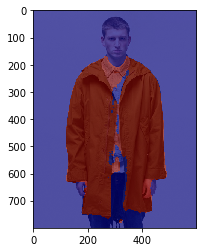

DetectedClass(area_ratio=0.3236885070800781, class_name='Outwear', class_id=5)


In [17]:
located_detection = locate_detection(detected_product, prediction)
resized_product = located_detection.resize(product_img)
resized_product.display(product_img)
print(detected_product)

Extract features.

In [18]:
product_subimage = resized_product.mask_to_image(product_img)
product_features = extract_features(product_subimage)
assert FEATURE_LENGTH == product_features.shape[0]

# Store all product features

In [19]:
def product_to_features(product: Product) -> Tuple[np.ndarray, int]:
    # Get predictions from product
    product_img = url_to_PIL(url=product.image_url)
    prediction = prediction_map(product_img)
    detections = get_detections(prediction, product)
        
    if len(detections) == 0:
        return np.zeros((FEATURE_LENGTH,)), -1
    else:
        located_detection = locate_detection(detections[0], prediction)
        resized_product = located_detection.resize(product_img)
        product_subimage = resized_product.mask_to_image(product_img)
        return extract_features(product_subimage), located_detection.class_id

example, example_id = product_to_features(products[5])

We are going to extract all features from the images and then store the product features into an H5 file. Let's, first, define the structure of the file.

In [56]:
# TODO remove
backup = products.copy()
products = [backup[np.random.randint(0, len(products))] for _ in range(25)]

In [57]:
with h5py.File('products.h5', 'w') as hf:
    
    # Store metadata
    str_type = h5py.special_dtype(vlen=str)
    url_dset = hf.create_dataset(
        'url',
        data=np.array([product.url for product in products], dtype='S')
    )
    name_dset = hf.create_dataset(
        'name',
        data=np.array([product.name for product in products], dtype='S')
    )
    image_url_dset = hf.create_dataset(
        'image_url',
        data=np.array([product.image_url for product in products], dtype='S')
    )
    section_dset = hf.create_dataset(
        'section',
        data=np.array([product.section for product in products], dtype='S')
    )
    
    # Compute and add all features
    # TODO: do in batches if memory error
    features, ids = zip(*[product_to_features(product) for product in products])
    class_id_dset = hf.create_dataset('class_id', data=ids)
    features_dset = hf.create_dataset('features', data=features)

# Query images

First, load feature matrix.

In [118]:
with h5py.File('products.h5', 'r') as hf:
    features = hf.get('features')[()]
    links = hf.get('url')[()]

In [119]:
test_img = Image.open('test.jpg')
test_prediction = prediction_map(test_img)
# test_img

Look for clothes in the image.

In [97]:
def get_strong_detections(class_image: np.ndarray,
                          class_area_thresh: float = 0.01) -> DetectedObject:
    """ Return relevant and robust detections sorted by area """
    detections = _detected_classes(class_image)
    # Get only predictions with enough area
    return list(
        filter(lambda x: x.area_ratio >= class_area_thresh, detections)
    )

test_detections = get_strong_detections(test_prediction)
located_detection = locate_detection(test_detections[0], test_prediction)
resized_detection = located_detection.resize(test_img)
product_subimage = resized_detection.mask_to_image(test_img)
test_features = extract_features(product_subimage)
test_pca_features = pca.transform([test_features])[0, :n_components]

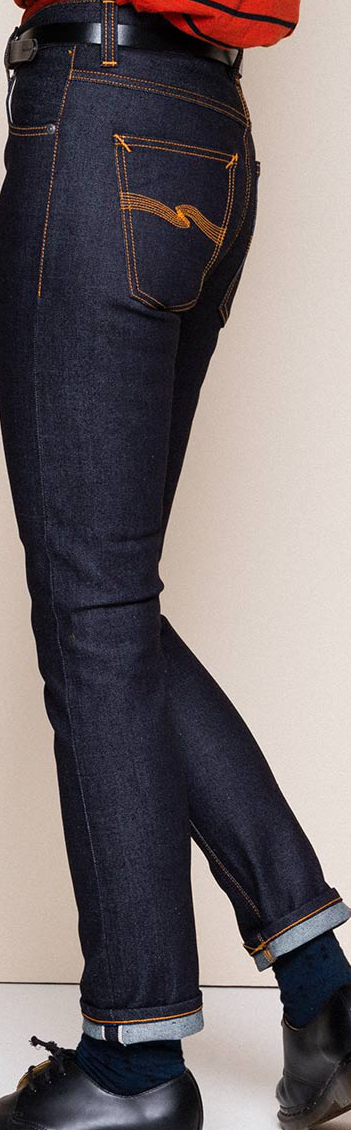

In [117]:
product_subimage

## Query using L2 norm

In [115]:
distances = [
    np.linalg.norm(test_pca_features - pca_features[i, ...])
    for i in range(len(pca_features))
]
sorted_dists_idxs = list(np.argsort(distances))

for i, idx in enumerate(sorted_dists_idxs):
    print(f'Rank #{i}: {links[idx]}({similarity[idx]})')

Rank #0: b'https://www.nudiejeans.com//product/lean-dean-indigo-shades'(0.035469911992549896)
Rank #1: b'https://www.nudiejeans.com//product/hightop-tilde-light-navy'(0.13679960370063782)
Rank #2: b'https://www.nudiejeans.com//product/skinny-lin-dark-blue-navy'(0.07070943713188171)
Rank #3: b'https://www.nudiejeans.com//product/henry-pigment-dyed-powder'(0.027853403240442276)
Rank #4: b'https://www.nudiejeans.com//product/dude-dan-ben-replica-rigid'(-0.02738121524453163)
Rank #5: b'https://www.nudiejeans.com//product/barney-worker-jacket-bunker'(0.020822327584028244)
Rank #6: b'https://www.nudiejeans.com//product/hightop-tilde-painted-black'(0.12681183218955994)
Rank #7: b'https://www.nudiejeans.com//product/dude-dan-dry-everblack'(0.0017497166991233826)
Rank #8: b'https://www.nudiejeans.com//product/steady-eddie-ii-dry-selvage'(-0.05217643082141876)
Rank #9: b'https://www.nudiejeans.com//product/lean-dean-broken-sage'(-0.081001415848732)
Rank #10: b'https://www.nudiejeans.com//product

## Query using L2 norm on PCA of computed features

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca = pca.fit(features)

In [ ]:
n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.80)[0])
pca_features = pca.transform(features)[:, :n_components]